# Semester 3 Coding Portfolio Topic 1 Summative:
# APIs and Scraping

In this notebook, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [1]:
# TODO: Please enter your student number here
STUDENT_NUMBER = ...

# SUMMATIVE ASSESSMENT

For this summative assignment, we ask you to get data from an internet source of choice. You have three options:
 - Using an API
 - Using request and BeautifulSoup
 - Using Selenium

The general assessment criteria for all summative assignments are mentioned in the assignment description on Canvas. Each notebook also has a few specific criteria we look for; make sure you fulfil them in your approach to this assignment.
In general, make sure this notebook represents a complete project: Write an explanation of what you are hoping to achieve with your data-collection, document your code well, and present results in a comprehensive way.
The assessment criteria for this notebook vary slightly depending on which method you chose to implement:

## API
 - Choose an API that is suitable for the data they need to scrape. Read the API documentation and decide how to collect the relevant data. 
 - Use knowledge to correctly form the relevant API requests, including necessary parameters and headers.
 - Implemented error handling for potential issues such as rate limits, missing data, or incorrect API responses.
 - Collect and organize the data effectively. Present it in a structured format, such as a clean and organized dataframe, rather than leaving it messy or unprocessed.
 - Demonstrate originality of code and creativity in your approach to acquiring and presenting the data.


<table>
<tr>

<!-- LEFT TEXT COLUMN -->
<td style="vertical-align: top; padding-right: 20px;">

Imagine: humanity suddenly decided to stop caring about wars, politics, and those silly problems, and remembered that **space exploration is the most interesting resource humanity can utilise!**

<br><br>

Well, that's roughly the plot of one of my favourite series called **"For All Mankind"**! The whole show is an alternative-reality scenario where humanity pushes the boundaries of space exploration far beyond what we currently have. (Highly recommend watching!)  
In the latest season, a crew of US and Soviet astronauts and cosmonauts **finally travels to Mars and builds a viable human colony.**

<br><br>

This notebook will explore that idea a bit further using two NASA APIs:  
**InSight** – the Mars weather service API, and the **NASA Image and Video Library**.  
I will generate a “Mars postcard” using the latest weather readings and connect them with real images from the InSight lander.


</td>

<!-- RIGHT IMAGES COLUMN -->
<td style="vertical-align: top; text-align:center;">

<img src="for-all-mankind1.png" width="900"><br><br>
<img src="for-all-mankind2.png" width="900"><br><br>
<img src="for-all-mankind3.png" width="900">

</td>

</tr>
</table>


In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import io
from IPython.display import Image, display
from matplotlib.gridspec import GridSpec

(1) **FIRST NASA API WITH ERROR HANDLING**

In [3]:
url = "https://api.nasa.gov/insight_weather/"

params = {
    "api_key": "fPgPWhtB3vg7XIt7MvlCW0bmaFo86LMH2K5SnG4g",
    "feedtype": "json",
    "ver": "1.0"
}

try:
    response = requests.get(url, params=params, timeout=10)
    response.raise_for_status() #raises an exception only if there is an error
    print(f"Status code: {response.status_code}")
except requests.exceptions.Timeout:
    print("Error: Request timed out.")
except requests.exceptions.ConnectionError:
    print("Error: Could not connect to the API.")
except requests.exceptions.HTTPError as e:
    print(f"Error: HTTP error occurred: {e}")

Status code: 200


(1.1) **PARSING JSON AND CHECKING STRUCTURE WITH ERROR HANDLING**

In [4]:
try:
    data = response.json()
    print(type(data))
    print(data.keys())
except ValueError:
    print("Error: Could not parse JSON response.")

<class 'dict'>
dict_keys(['675', '676', '677', '678', '679', '680', '681', 'sol_keys', 'validity_checks'])


(1.2) **AVAILABLE DATA FOR MARTIAN DAYS, CHECK DATA FOR FIRST MARTIAN DAY AND ERROR HANDLING**

In [5]:
if 'sol_keys' in data and len(data['sol_keys']) > 0:
    print("Available Sols:", data['sol_keys'])
    first_sol = data['sol_keys'][0]
    print(f"\nData for Sol {first_sol}:")
    print(data[first_sol])
else:
    print("Error: No Sol data available.")

Available Sols: ['675', '676', '677', '678', '679', '680', '681']

Data for Sol 675:
{'AT': {'av': -62.314, 'ct': 177556, 'mn': -96.872, 'mx': -15.908}, 'First_UTC': '2020-10-19T18:32:20Z', 'HWS': {'av': 7.233, 'ct': 88628, 'mn': 1.051, 'mx': 22.455}, 'Last_UTC': '2020-10-20T19:11:55Z', 'Month_ordinal': 10, 'Northern_season': 'early winter', 'PRE': {'av': 750.563, 'ct': 887776, 'mn': 722.0901, 'mx': 768.791}, 'Season': 'fall', 'Southern_season': 'early summer', 'WD': {'0': {'compass_degrees': 0.0, 'compass_point': 'N', 'compass_right': 0.0, 'compass_up': 1.0, 'ct': 254}, '1': {'compass_degrees': 22.5, 'compass_point': 'NNE', 'compass_right': 0.382683432365, 'compass_up': 0.923879532511, 'ct': 1}, '10': {'compass_degrees': 225.0, 'compass_point': 'SW', 'compass_right': -0.707106781187, 'compass_up': -0.707106781187, 'ct': 8618}, '11': {'compass_degrees': 247.5, 'compass_point': 'WSW', 'compass_right': -0.923879532511, 'compass_up': -0.382683432365, 'ct': 1912}, '12': {'compass_degrees':

(1.3) **PANDAS DF FOR THE 7 AVAILABLE MARTIAN DAYS**

In [6]:
# Create an empty list to store our processed data
weather_data = []

# Loop through each Sol
for sol in data['sol_keys']:
    sol_data = data[sol]
    
    # Build a dictionary for this Sol's data
    sol_dict = {
        'sol': sol,
        'first_utc': sol_data.get('First_UTC'),
        'last_utc': sol_data.get('Last_UTC'),
        'season': sol_data.get('Season'),
        'northern_season': sol_data.get('Northern_season'),
        'southern_season': sol_data.get('Southern_season')
    }
    
    # Add temperature data (if it exists)
    if 'AT' in sol_data:
        sol_dict['temp_avg'] = sol_data['AT'].get('av')
        sol_dict['temp_min'] = sol_data['AT'].get('mn')
        sol_dict['temp_max'] = sol_data['AT'].get('mx')
    
    # Add wind speed data (if it exists)
    if 'HWS' in sol_data:
        sol_dict['wind_speed_avg'] = sol_data['HWS'].get('av')
        sol_dict['wind_speed_min'] = sol_data['HWS'].get('mn')
        sol_dict['wind_speed_max'] = sol_data['HWS'].get('mx')
    
    # Add pressure data (if it exists)
    if 'PRE' in sol_data:
        sol_dict['pressure_avg'] = sol_data['PRE'].get('av')
        sol_dict['pressure_min'] = sol_data['PRE'].get('mn')
        sol_dict['pressure_max'] = sol_data['PRE'].get('mx')
    
    # Add this Sol to our list
    weather_data.append(sol_dict)

# Convert to dataframe
df = pd.DataFrame(weather_data)
df

,sol,first_utc,last_utc,season,northern_season,southern_season,temp_avg,temp_min,temp_max,wind_speed_avg,wind_speed_min,wind_speed_max,pressure_avg,pressure_min,pressure_max
0,675,2020-10-19T18:32:20Z,2020-10-20T19:11:55Z,fall,early winter,early summer,-62.314,-96.872,-15.908,7.233,1.051,22.455,750.563,722.0901,768.7910
1,676,2020-10-20T19:11:55Z,2020-10-21T19:51:31Z,fall,early winter,early summer,-62.812,-96.912,-16.499,8.526,1.110,26.905,749.090,722.4730,767.1426
2,677,2020-10-21T19:51:31Z,2020-10-22T20:31:06Z,fall,mid winter,mid summer,-63.056,-97.249,-16.853,7.887,0.511,23.197,748.698,720.5873,767.4249
3,678,2020-10-22T20:31:06Z,2020-10-23T21:10:41Z,fall,mid winter,mid summer,-62.562,-97.728,-9.055,5.246,0.244,18.399,743.741,717.7254,760.2834
4,679,2020-10-23T21:10:41Z,2020-10-24T21:50:16Z,fall,mid winter,mid summer,-62.551,-96.644,-11.561,5.565,0.231,19.409,744.529,719.4178,763.2724
5,680,2020-10-24T21:50:16Z,2020-10-25T22:29:51Z,fall,mid winter,mid summer,-61.789,-96.811,-15.298,6.517,0.275,24.235,743.990,717.1398,764.0093
6,681,2020-10-25T22:29:51Z,2020-10-26T23:09:26Z,fall,mid winter,mid summer,-62.434,-95.447,-4.444,5.632,0.228,18.577,743.550,718.4630,760.2244


(2) **SECOND NASA API WITH ERROR HANDLING**

In [7]:
# Search for InSight lander images
image_url = "https://images-api.nasa.gov/search"

image_params = {
    "q": "InSight Mars",
    "media_type": "image"
}

try:
    image_response = requests.get(image_url, params=image_params, timeout=10)
    image_response.raise_for_status()
    image_data = image_response.json()
    print(f"Status: {image_response.status_code}")
    print(f"Number of results: {len(image_data['collection']['items'])}")
except requests.exceptions.RequestException as e:
    print(f"Error: {e}")

Status: 200
Number of results: 100


(2.1) **CHECK API RESPONSE STRUCTURE (KEYS, FIRST DATA + LINKS) AND ERROR HANDLING**

In [8]:
if 'collection' not in image_data:
    print("Error: no 'collection' key in response.")
elif 'items' not in image_data['collection']:
    print("Error: collection has no 'items' list.")
elif len(image_data['collection']['items']) == 0:
    print("Error: items list is empty.")
else:
    first_item = image_data['collection']['items'][0]

    print("Keys:", first_item.keys())

    if 'data' in first_item and first_item['data']:
        print("\nData:", first_item['data'][0])
    else:
        print("\nError: no data available.")

    links = first_item.get('links')
    print("\nLinks:", links if links else "No links")



Keys: dict_keys(['href', 'data', 'links'])

Data: {'center': 'JPL', 'date_created': '2019-05-01T00:00:00Z', 'description': "NASA's InSight lander used the Instrument Deployment Camera (IDC) on the end of its robotic arm to image this sunset on Mars on April 25, 2019, the 145th Martian day, or sol, of the mission. This was taken around 6:30 p.m. Mars local time.  https://photojournal.jpl.nasa.gov/catalog/PIA23202", 'description_508': "NASA's InSight lander used the Instrument Deployment Camera (IDC) on the end of its robotic arm to image this sunset on Mars on April 25, 2019.", 'keywords': ['InSight', 'Mars'], 'media_type': 'image', 'nasa_id': 'PIA23202', 'secondary_creator': 'NASA/JPL-Caltech', 'title': 'InSight Images a Sunset on Mars'}

Links: [{'href': 'https://images-assets.nasa.gov/image/PIA23202/PIA23202~small.jpg', 'rel': 'alternate', 'render': 'image', 'width': 640, 'size': 27000, 'height': 640}, {'href': 'https://images-assets.nasa.gov/image/PIA23202/PIA23202~thumb.jpg', 'rel'

(2.2) **DISPLAY FIRST ITEM**

In [9]:
# Get the image URL (using the original/largest version)
image_url = first_item['links'][0]['href']  # index 2 is the orig size
print(f"Title: {first_item['data'][0]['title']}")
print(f"URL: {image_url}")

# Display it
display(Image(url=image_url, width=500))

Title: InSight Images a Sunset on Mars
URL: https://images-assets.nasa.gov/image/PIA23202/PIA23202~small.jpg


(3) **CREATE FIRST POSTCARD FROM MARS**

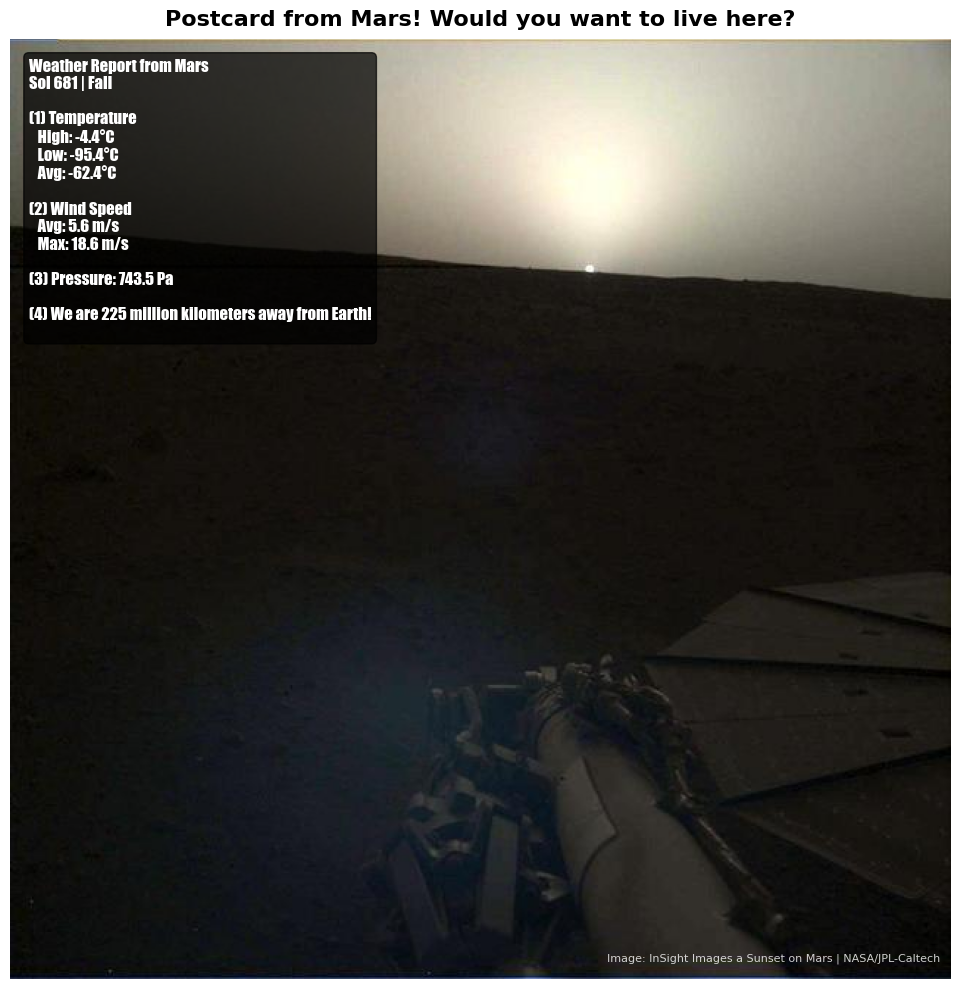

In [10]:
# Download the image
img_response = requests.get(image_url)
img = PILImage.open(io.BytesIO(img_response.content))

#get latest sol weather data from df before
latest_sol = df.iloc[-1]  #last row = most recent Sol

#create the figure
fig, ax = plt.subplots(figsize=(12, 10))

#Mars image display
ax.imshow(img)
ax.axis('off')

#semi-transparent overlay box
props = dict(boxstyle='round', facecolor='black', alpha=0.7)

#initialising weather text variable
weather_text = f"""Weather Report from Mars
Sol {latest_sol['sol']} | {latest_sol['season'].title()}

(1) Temperature
   High: {latest_sol['temp_max']:.1f}°C
   Low: {latest_sol['temp_min']:.1f}°C
   Avg: {latest_sol['temp_avg']:.1f}°C

(2) Wind Speed
   Avg: {latest_sol['wind_speed_avg']:.1f} m/s
   Max: {latest_sol['wind_speed_max']:.1f} m/s

(3) Pressure: {latest_sol['pressure_avg']:.1f} Pa

(4) We are 225 million kilometers away from Earth!
"""

#add text to image
ax.text(0.02, 0.98, weather_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', fontfamily='fantasy',
        color='white', bbox=props)

#add title
ax.set_title("Postcard from Mars! Would you want to live here?", fontsize=16, fontweight='bold', pad=10)

#image credit (we know plagiarism is bad)
ax.text(0.99, 0.02, f"Image: {first_item['data'][0]['title']} | NASA/JPL-Caltech",
        transform=ax.transAxes, fontsize=8, ha='right', color='white', alpha=0.8)

plt.tight_layout()
plt.show()

(3.1) **PICK FAVOURITE IMAGES FOR THE POSTCARD**

In [11]:
#preview ALL available images
for i, item in enumerate(image_data['collection']['items']):  # Removed [:20]
    title = item['data'][0]['title']
    print(f"[{i}] {title}")

[0] InSight Images a Sunset on Mars
[1] InSight Images a Sunrise on Mars
[2] How InSight Studies Mars' Inner Layers
[3] InSight's First Image from Mars
[4] InSight's Final Location on Mars
[5] Vibrations from InSight's First 20 Minutes on Mars
[6] InSight's First View of Mars with the Cover Off
[7] InSight on Mars, As Seen by HiRISE
[8] InSight Images Clouds on Mars
[9] Landing Area Narrowed for 2016 InSight Mission to Mars
[10] InSight Approaching Mars
[11] InSight Probes the 'Inner Space' of Mars
[12] InSight on the Surface of Mars
[13] One of InSight's Last Images
[14] Locations of InSight, its Heat Shield and its Parachute
[15] Marsforming With HoloLens
[16] InSight Robotic Arm Test Lift of Wind and Thermal Shield
[17] Putting SEIS on the Ground
[18] Soil Churned up by InSight's Thrusters
[19] Unlatching InSight's Arm
[20] Pits Under InSight Lander
[21] Marsforming for InSight
[22] Replica of InSight's Arm Practices Scraping
[23] InSight Moments Away From Landing, Top View (Illustr

Note wanted indexes: [0] - yes, [1] - yes, [8] - yes, [10] - yes, [12] - yes, [13] - yes, [49] - yes.


In the cell below I just went through the indeces of images and displayed them because I wanted to hand pic the images. 

In [12]:
#picking image with specific index
chosen_image = image_data['collection']['items'][6]  #i swapped the indeces to check specific images

#prep for display
image_url = chosen_image['links'][0]['href']  #links[0] - small, links[2] - original
print(f"Title: {chosen_image['data'][0]['title']}")  # data[0], not data[1]
print(f"URL: {image_url}")

display(Image(url=image_url, width=500))

Title: InSight's First View of Mars with the Cover Off
URL: https://images-assets.nasa.gov/image/PIA22893/PIA22893~small.jpg


(4) **CREATE A FULL FORECAST POSTCARD FROM MARS**

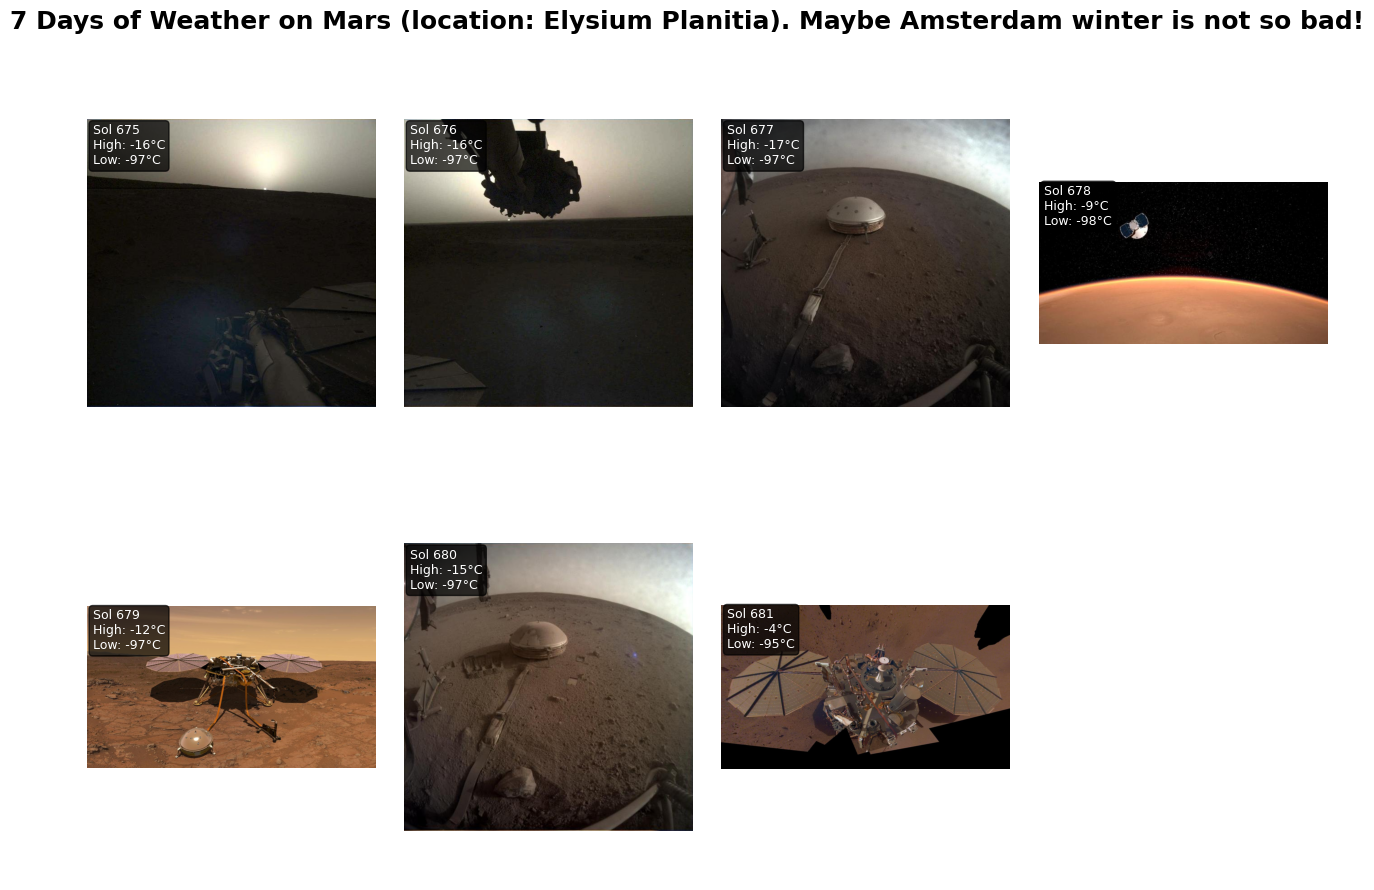

In [13]:
#store hand-picked image indices in a list
chosen_indices = [0, 1, 8, 10, 12, 13, 49]

#get those specific images
images_to_use = [image_data['collection']['items'][i] for i in chosen_indices]

fig = plt.figure(figsize=(16, 10))

#custom positions: 4 on top, 3 centered on bottom
positions = [
    (0, 0), (0, 1), (0, 2), (0, 3),  #top row 4 regular layout
    (1, 0.5), (1, 1.5), (1, 2.5)     #bottom row: 3 images, offset by 0.5 to center
]

# Create a GridSpec for better control
#gridsec part of matplotlib tool kit, i use it to have more control over subplot placament
#didn't like the default tight layout and images are diff sizes 
gs = GridSpec(2, 4, figure=fig, hspace=0.1, wspace=0.1)

#top row - 4 images
for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    sol_row = df.iloc[i]
    
    img_url = images_to_use[i]['links'][0]['href']
    try:
        img_response = requests.get(img_url, timeout=10)
        img = PILImage.open(io.BytesIO(img_response.content))
        ax.imshow(img)
    except:
        pass
    
    ax.axis('off')
    props = dict(boxstyle='round', facecolor='black', alpha=0.7)
    weather_text = f"Sol {sol_row['sol']}\nHigh: {sol_row['temp_max']:.0f}°C\nLow: {sol_row['temp_min']:.0f}°C"
    ax.text(0.02, 0.98, weather_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', color='white', bbox=props)

#bottom row - 3 images (skip first and last column)
for i, col in enumerate([0, 1, 2]):
    ax = fig.add_subplot(gs[1, col])
    sol_row = df.iloc[i + 4]
    
    img_url = images_to_use[i + 4]['links'][0]['href']
    try:
        img_response = requests.get(img_url, timeout=10)
        img = PILImage.open(io.BytesIO(img_response.content))
        ax.imshow(img)
    except:
        pass
    
    ax.axis('off')
    props = dict(boxstyle='round', facecolor='black', alpha=0.7)
    weather_text = f"Sol {sol_row['sol']}\nHigh: {sol_row['temp_max']:.0f}°C\nLow: {sol_row['temp_min']:.0f}°C"
    ax.text(0.02, 0.98, weather_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', color='white', bbox=props)

#hide last empty subplot
ax_empty = fig.add_subplot(gs[1, 3])
ax_empty.axis('off')

plt.suptitle("7 Days of Weather on Mars (location: Elysium Planitia). Maybe Amsterdam winter is not so bad!", fontsize=18, fontweight='bold')
plt.subplots_adjust(top=0.92)
plt.show()

<div style="
    max-width: 750px;
    margin: 0 auto;
    border: 2px solid #444;
    border-radius: 10px;
    padding: 20px 28px;
    background: #1e1e1e;
    color: #eee;
    line-height: 1.6;
    font-size: 16px;
">

<h3 style="margin-top: 0; color: #4e44dfff;">Final Thoughts</h3>

<p>
Hooray! Now we know what the crew from <strong>"For All Mankind"</strong> had to withstand on Mars.  
The fierce winds, the extreme cold, and the harsh conditions paint a vivid picture of what life on the Red Planet could truly be like.
</p>

<p>
It makes me wonder: <em>when will humans finally get the chance to experience this in reality?</em>  
Space exploration may still be in its early chapters, but every mission brings us one step closer.
</p>

</div>
